## Gaussian Process Regression (GPR) 

In [23]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mixture_model import *
from plot_utils import *
from numpy.linalg import norm as norm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Declare Parameters 

In [105]:
n_in = 1 #dimension of x
n_out = 1 #dimension of y
n_data = 6 #number of datapoints
n_data_reprod = 100 #number of datapoints in a reproduction
n_reprod = 20 #number of randomly sampled reproductions
params = np.array([1, 0.1, 1e-4]) #GPR parameters: output scale, input scale and the noise variance
                                    #(here defined for squared exponential kernels and noisy observations)

#### Generate Random Data 

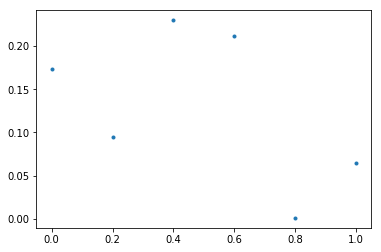

In [110]:
x = np.linspace(0,1,n_data)
y = np.random.rand(n_data)*0.3
data = np.vstack([x,y]).T
plt.plot(x,y,'.')

#### Define functions for GPR 

In [111]:
def RBF_cov_function(x1,x2,params):
    return params[0] * np.exp(-(norm(x1-x2)**2)/params[1])

def compute_cov_matrix(X1,X2,params, cov_func = RBF_cov_function):
    #You can define other covariance function to replace RBF_cov_function
    n_row = len(X1)
    n_col = len(X2)
    K = np.zeros((n_row, n_col))
    for i in range(n_row):
        for j in range(n_col):
            K[i,j] = cov_func(X1[i], X2[j], params)
            
    return K

#### Compute the GPR parameters (the covariance matrix) 

In [112]:
K = compute_cov_matrix(x,x,params)
K_inv = np.linalg.pinv(K + params[2]*np.eye(K.shape[0]))

#### Given the input xs, compute the prediction 

In [113]:
xs = np.linspace(0,1,n_data_reprod) #the input

#Mean computation 
Ks = compute_cov_matrix(xs,x,params)
ys = np.dot(Ks, np.dot(K_inv,y)) # the mean
#Uncertainty evaluation 
Kss = compute_cov_matrix(xs,xs,params)
S = Kss - np.dot(Ks, np.dot(K_inv, Ks.T)) #the covariance

#### Plot Prior Samples 

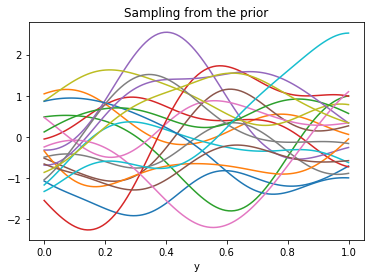

In [114]:
#define the prior distribution
prior_traj_dist = mvn(mean = np.zeros(n_data_reprod), cov=Kss, allow_singular=True)
#sampling from the prior distribution
prior_samples = prior_traj_dist.rvs(size=n_reprod)

for ys_i in prior_samples:
    plt.plot(xs, ys_i)
plt.title('Sampling from the prior')
plt.xlabel('x')
plt.xlabel('y')
plt.show()

#### Plot Posterior Samples 

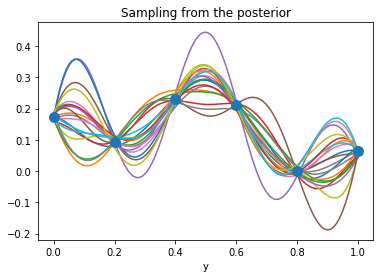

In [115]:
#define the posterior distribution based on the GPR prediction
post_traj_dist = mvn(mean = ys, cov=S, allow_singular=True)
#sampling from the posterior distribution
post_samples = post_traj_dist.rvs(size=n_reprod)

for ys_i in post_samples:
    plt.plot(xs, ys_i)
plt.plot(x,y,'.',markersize=20)
plt.title('Sampling from the posterior')
plt.xlabel('x')
plt.xlabel('y')
plt.show()

#### Plot trajectory distributions 

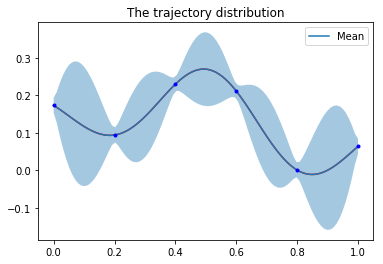

In [120]:
sigmas = np.diagonal(S)
fig,ax = plt.subplots()
plot_with_covs_1D(xs,ys,sigmas,ax)
plt.plot(xs,ys,'-',label='Mean')
plt.plot(x,y,'.b')
plt.legend()
plt.title('The trajectory distribution')
plt.show()